# 不用pytorch的dataloader版本的卷积神经网络

1. 首先，我们需要学习PyTorch自带的数据加载器，包括dataset，sampler，以及data loader这三个对象组成的套件。

2. 当数据集很小，格式比较规则的时候，数据加载三套件的优势并不明显。但是当数据格式比较特殊，以及数据规模很大（内存无法同时加载所有数据）
的时候，特别是，我们需要用不同的处理器来加载数据的时候，三套件的威力就会显现出来了。它会将数据加载、分布的任务自动完成。

3. 在使用的时候，我们用dataset来装载数据集，用sampler来采样数据集。而对数据集的迭代、循环则主要通过data_loader来完成。

In [2]:
# 不用pytorch的dataloader版本的卷积神经网络

import gzip
import os
import sys

from six.moves import urllib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

#定义一系列常数
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/' #图像数据如果没下载，可以从这个地址下载
WORK_DIRECTORY = '05_convolution_data_raw' #存储的路径名
IMAGE_SIZE = 28 #每张图片的大小尺寸
NUM_CHANNELS = 1  #每张图片的通道数
PIXEL_DEPTH = 255 #像素的深度0-255
NUM_LABELS = 10 #手写数字，一共十种
VALIDATION_SIZE = 5000 #校验数据集大小
NUM_EPOCHS = 20 # 训练的循环周期
BATCH_SIZE = 64 #batch的大小
EVAL_FREQUENCY = 100 #每隔100个batch进行一次校验集计算


In [3]:
#下载图像文件，如果文件已经存在，那么就不下载。
def maybe_download(filename):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.isdir(WORK_DIRECTORY):
        os.mkdir(WORK_DIRECTORY)
    filepath = os.path.join(WORK_DIRECTORY, filename)
    print(filepath)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        size = os.path.getsize(filepath)
        print('Successfully downloaded', filename, size, 'bytes.')
    return filepath
# Get the data.
train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

5_convolution_data_raw/train-images-idx3-ubyte.gz
5_convolution_data_raw/train-labels-idx1-ubyte.gz
5_convolution_data_raw/t10k-images-idx3-ubyte.gz
5_convolution_data_raw/t10k-labels-idx1-ubyte.gz


In [4]:
def extract_data(filename, num_images):
    # filename: 文件存放的路径，num_images: 读入的图片个数
    """将图像解压缩展开，读入成一个4维的张量： [image index（图像的编码）, y（纵坐标）, x（横坐标）, channels（通道）].
    我们将数组中的数值范围从原来的[0, 255]降低到了[-0.5, 0.5]范围内
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16) # 前16个字节分别存放magic number,number of images,number of rows,number of columns
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH  # 压缩像素值
        data = data.reshape(num_images, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return data

def extract_labels(filename, num_images):
    """将label的数据文件解压缩，并将label读成64位的整数"""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8) # 前8个字节分别存放magic number， number of items
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

# 将数据解压缩并存储到数组中，60000张图片，60000个label，测试集中有10000张图片
train_data = extract_data(train_data_filename, 60000)
train_labels = extract_labels(train_labels_filename, 60000)
test_data = extract_data(test_data_filename, 10000)
test_labels = extract_labels(test_labels_filename, 10000)

# 将一部分图片（VALIDATION_SIZE=5000张）定为校验数据集
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]
num_epochs = NUM_EPOCHS

Extracting 5_convolution_data_raw/train-images-idx3-ubyte.gz
Extracting 5_convolution_data_raw/train-labels-idx1-ubyte.gz
Extracting 5_convolution_data_raw/t10k-images-idx3-ubyte.gz
Extracting 5_convolution_data_raw/t10k-labels-idx1-ubyte.gz


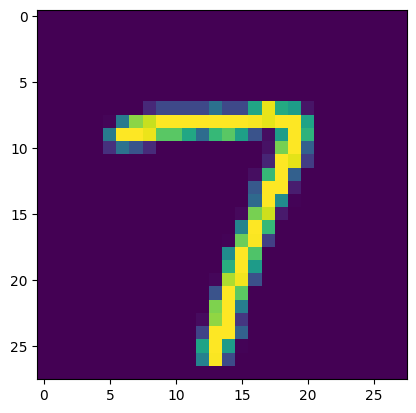

In [5]:
#随便从数据集中读入一张图片，并绘制出来
idx = 100
muteimg = train_data[idx, 0, :, :]
plt.imshow(muteimg)

In [6]:
# 定义关键函数

def error_rate(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，labels是数据之中的正确答案"""
    predictions = np.argmax(predictions, 1)
    return 100.0 - (100.0 * np.sum( predictions == labels) / predictions.shape[0])

def eval_in_batches(data, net):
    """计算得到预测精度，运行对所有的数据集中的小撮数据进行."""
    size = data.shape[0]
    if size < BATCH_SIZE:
        raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = np.ndarray(shape=(size, NUM_LABELS), dtype=np.float32)
    
    #一个小撮一个小撮地进行预测的计算
    for begin in range(0, size, BATCH_SIZE):
        end = begin + BATCH_SIZE
        if end <= size:
            inputs = data[begin:end]
            inputs = torch.from_numpy(inputs)
            inputs = inputs.clone().detach().requires_grad_(True)
            outputs = net(inputs)
            predictions[begin:end, :] = outputs.data.numpy()
        else:
            inputs = data[-BATCH_SIZE:]
            inputs = torch.from_numpy(inputs)
            inputs = inputs.clone().detach().requires_grad_(True)
            outputs = net(inputs)
            
            batch_predictions = outputs.data.numpy()
            predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

In [7]:
# 构建卷积神经网络
depth = [4, 8] # 卷积层的厚度

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()  # 调用父类构造函数

        # 卷积后图像维度不变， size + padding * 2 - kernel_size + 1 = size + 4 - 5 + 1 = size
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = 5, padding = 2) # 卷积层
        
        self.pool = nn.MaxPool2d(2, 2) #  池化层
        
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2) # 第二层卷积

        self.fc1 = nn.Linear(IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * depth[1], 512) 
        self.fc2 = nn.Linear(512, NUM_LABELS)
        
    def forward(self, x):
        # 神经网络完成真正的前向运算，拼装各个实际的组件
        x = self.conv1(x) # 第一层卷积
        x = F.relu(x)  # (batch_size, num_filters, image_width, image_height]

        x = self.pool(x) # 第二层池化，图片变小：(batch_size, num_filters, image_width / 2, image_height / 2]

        x = self.conv2(x) #第三层卷积, (batch_size, depth[1], image_width / 2, image_height / 2]
        x = F.relu(x)  

        x = self.pool(x) #第四层池化， 图片缩小 (batch_size, depth[1], image_width / 2 / 2, image_height / 2 / 2]

        x = x.view(-1, IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * depth[1])  # 压缩向量

        x = F.relu(self.fc1(x)) # 第五层为全连接  (batch_size, 512)

        x = F.dropout(x, training = self.training) # 默认以0.5的概率对这一层进行dropout操作，防止过拟合
        x = self.fc2(x)  # 全连接层，最终输出 （batch_size, num_classes）

        x = F.log_softmax(x, dim=1)
        return x

    def retrieve_features(self, x):
        # 返回前两层卷积层的特征图
        feature_map1 = F.relu(self.conv1(x))
        x = self.pool(feature_map1)

        feature_map2 = F.relu(self.conv2(x))
        return (feature_map1, feature_map2)

In [8]:
error_rate_rec = []

#获得训练集尺寸
train_size = train_labels.shape[0]

print('Initialized!')

net = ConvNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 开始训练循环，一共进行int(num_epochs * train_size) // BATCH_SIZE次
print('Total loops: {}, Epoch: {}\n'.format(int(num_epochs * train_size) // BATCH_SIZE, NUM_EPOCHS))
for step in range(int(num_epochs * train_size) // BATCH_SIZE):
    # 计算当前应该访问训练集中的哪一部分数据
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_data = train_data[offset:(offset + BATCH_SIZE), ...]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    batch_data = torch.from_numpy(batch_data)
    batch_labels = torch.from_numpy(batch_labels)
    
    inputs, labels = batch_data.clone().detach(), batch_labels.clone().detach()
    
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    #print(loss)
    loss.backward()
    optimizer.step()
    
    if step % EVAL_FREQUENCY == 0:
        #每间隔EVAL_FREQUENCY就打印一次预测结果

        #print('损失函数值: %.3f, 学习率: %.6f' % (l, lr))
        predictions = outputs.data.numpy()
        #print(predictions.shape)
        err_train = error_rate(predictions, labels.data.numpy())
        prediction = eval_in_batches(validation_data, net)
        err_valid = error_rate(prediction, validation_labels)

        print('第 {} (epoch: {:.2f}) 步:\t 训练集测试率: {:.2f}%,\t校验集测试率: {:.2f}%'.format(
            step, float(step) * BATCH_SIZE / train_size, 
            err_train, err_valid
        ))

        error_rate_rec.append([err_train,err_valid])
        sys.stdout.flush()
# 在测试集上实验
prediction = eval_in_batches(test_data, net)
test_error = error_rate(prediction, test_labels)
print('测试误差: %.1f%%' % test_error)


Initialized!
Total loops: 17187, Epoch: 20

第 0 (epoch: 0.00) 步:	 训练集测试率: 95.31%,	校验集测试率: 88.76%
第 100 (epoch: 0.12) 步:	 训练集测试率: 82.81%,	校验集测试率: 85.82%
第 200 (epoch: 0.23) 步:	 训练集测试率: 87.50%,	校验集测试率: 81.60%
第 300 (epoch: 0.35) 步:	 训练集测试率: 78.12%,	校验集测试率: 75.16%
第 400 (epoch: 0.47) 步:	 训练集测试率: 64.06%,	校验集测试率: 67.58%
第 500 (epoch: 0.58) 步:	 训练集测试率: 54.69%,	校验集测试率: 60.46%
第 600 (epoch: 0.70) 步:	 训练集测试率: 53.12%,	校验集测试率: 49.32%
第 700 (epoch: 0.81) 步:	 训练集测试率: 37.50%,	校验集测试率: 33.18%
第 800 (epoch: 0.93) 步:	 训练集测试率: 32.81%,	校验集测试率: 23.90%
第 900 (epoch: 1.05) 步:	 训练集测试率: 25.00%,	校验集测试率: 18.14%
第 1000 (epoch: 1.16) 步:	 训练集测试率: 20.31%,	校验集测试率: 15.38%
第 1100 (epoch: 1.28) 步:	 训练集测试率: 6.25%,	校验集测试率: 13.48%
第 1200 (epoch: 1.40) 步:	 训练集测试率: 10.94%,	校验集测试率: 11.70%
第 1300 (epoch: 1.51) 步:	 训练集测试率: 3.12%,	校验集测试率: 11.40%
第 1400 (epoch: 1.63) 步:	 训练集测试率: 9.38%,	校验集测试率: 10.04%
第 1500 (epoch: 1.75) 步:	 训练集测试率: 10.94%,	校验集测试率: 9.68%
第 1600 (epoch: 1.86) 步:	 训练集测试率: 4.69%,	校验集测试率: 8.94%
第 1700 (epoch: 1.98) 步

Text(0, 0.5, 'Error Rate')

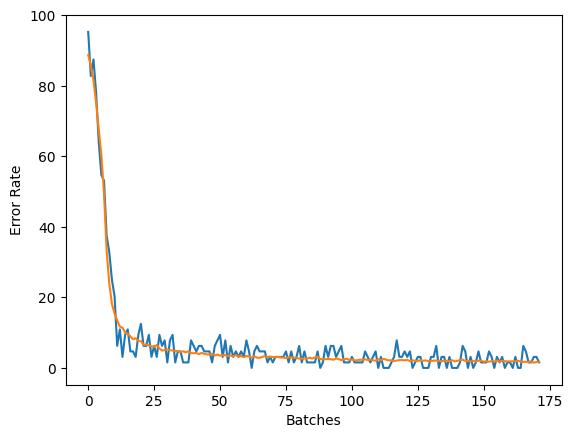

In [9]:
plt.plot(error_rate_rec)
plt.xlabel('Batches')
plt.ylabel('Error Rate')

In [10]:
#将测试集喂进去，得到计算结果，看一看预测的准确度
right = 0
batch_num = len(test_data) // BATCH_SIZE
for i in range(batch_num):
    inputs = test_data[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
    inputs = torch.from_numpy(inputs)
    inputs = inputs.clone().detach()
    result = net(inputs)
    result = result.data.numpy()
    
    labels = test_labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]
    right += np.sum(np.argmax(result, 1) == labels)
print(right / float(batch_num * BATCH_SIZE))

0.9820713141025641
